In [1]:
%pylab inline --no-import-all
import seaborn as sns
import scipy as sp
import scipy.ndimage
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.optimizers import SGD
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [51]:
train = pd.read_csv("/home/denis/train.csv")

In [52]:
def decode_one_hot(encoded):
    return np.apply_along_axis(np.argmax, axis=1, arr=encoded)

def evaluate_accuracy(predicted, expected): 
    return ("model accuracy on test data: {:.3f}%"
            .format(100 * (1.0 - (predicted != expected).sum() / expected.shape[0])) )

In [58]:
cnn_model = Sequential([
    # input shape is (28, 28, 1), i.e. 28x28 pixels image with 1 color chanel (grayscale)
    
    ZeroPadding2D(padding=(1, 1), input_shape=(28, 28, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    ZeroPadding2D(padding=(1, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    ZeroPadding2D(padding=(1, 1)),
    Conv2D(64, (3, 3), activation='relu', strides=(2,2)),
    ZeroPadding2D(padding=(1, 1)),
    Conv2D(64, (3, 3), activation='relu', strides=(2,2)),
    AveragePooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu', kernel_initializer='random_uniform'),
    Dropout(0.25),
    Dense(128, activation='relu', kernel_initializer='random_uniform'),
    Dropout(0.125),
    
    Dense(10, activation='softmax', kernel_initializer='random_uniform')
])

cnn_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [59]:
trainX = train.loc[:, 'pixel0':].as_matrix().astype(int).reshape((-1, 28, 28, 1))
cnn_model.fit(trainX, keras.utils.to_categorical(train['label']), validation_split=0.2, batch_size=50, epochs=5)

Train on 33600 samples, validate on 8400 samples
Epoch 1/5
33600/33600 [==============================] - 14s - loss: 0.3232 - acc: 0.8970 - val_loss: 0.0921 - val_acc: 0.9714
Epoch 2/5
33600/33600 [==============================] - 13s - loss: 0.1056 - acc: 0.9686 - val_loss: 0.0688 - val_acc: 0.9806
Epoch 3/5
33600/33600 [==============================] - 13s - loss: 0.0823 - acc: 0.9771 - val_loss: 0.0521 - val_acc: 0.9850
Epoch 4/5
33600/33600 [==============================] - 13s - loss: 0.0739 - acc: 0.9796 - val_loss: 0.0551 - val_acc: 0.9858
Epoch 5/5
33600/33600 [==============================] - 13s - loss: 0.0697 - acc: 0.9806 - val_loss: 0.0437 - val_acc: 0.9898


In [60]:
import matplotlib.patches as mpatches

def error_plot(predictions, true):
    def what_is_predicted(predictions, instead_of):
        return predictions[np.all(
            (predictions != true, true == instead_of),
            axis=0)]

    fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
    colors = [
        "#B76C6C",
        "#B78B6C",
        "#B3B76C",
        "#90B76C",
        "#6CB77E",
        "#6CB7B2",
        "#6C96B7",
        "#6C76B7",
        "#906CB7",
        "#B76CB5"
    ]
    plt.xticks(np.arange(10), size=16)
    plt.xlabel("What should be", size=20)
    plt.ylabel("Wrong predictions", size=20)


    wrong_numbers = [np.bincount(what_is_predicted(predictions, i)) for i in range(0, 10)]
    result = []
    for i, num in enumerate(wrong_numbers):
        bottom = 0
        for j, error in enumerate(num):
            if error:
                result.append(ax.bar(i, error, bottom=bottom, color=colors[j]))       
                ax.text(i, bottom + error*0.5 - 0.1, j,
                        verticalalignment='center',
                        horizontalalignment='center',
                        size=10, weight='bold')

                bottom += error

    ax.legend(handles = [mpatches.Patch(color=colors[i], label=i) for i in reversed(range(10))])

In [62]:
predictions = cnn_model.predict(trainX)
decoded = decode_one_hot(predictions)
error_idx = decoded != train['label']
wrong = predictions[error_idx]
true = train['label'][error_idx]

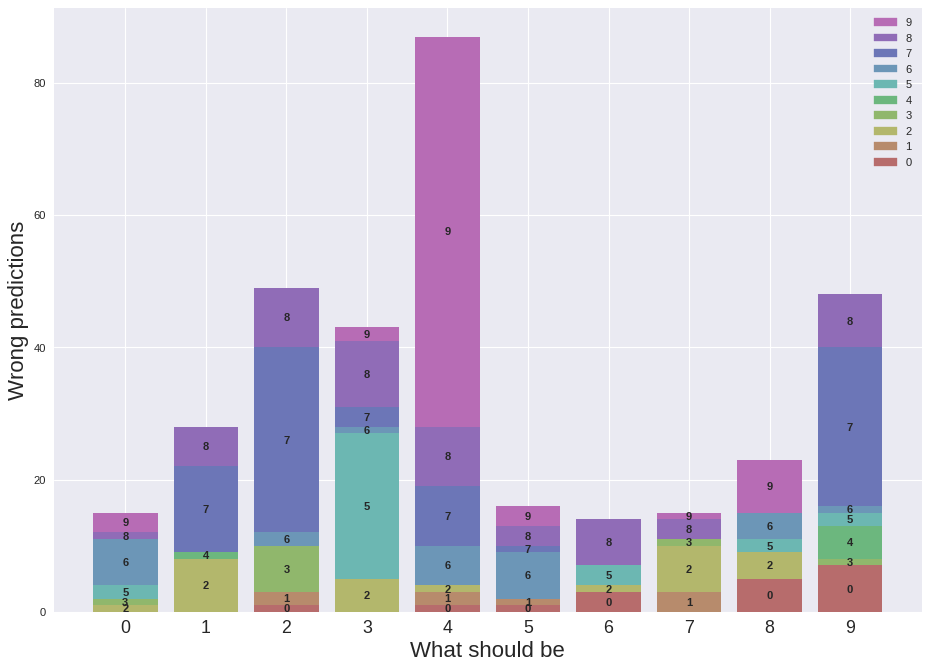

In [63]:
error_plot(decode_one_hot(predictions), train['label'])

In [64]:
def check_certain(certainty):
    return lambda probs: sorted(probs, reverse=True)[0] > certainty
    
uncertain_errors = np.apply_along_axis(lambda x: not check_certain(0.6)(x), 1, wrong).reshape(len(wrong))
certain_errors = np.apply_along_axis(check_certain(0.9), 1, wrong).reshape(len(wrong))

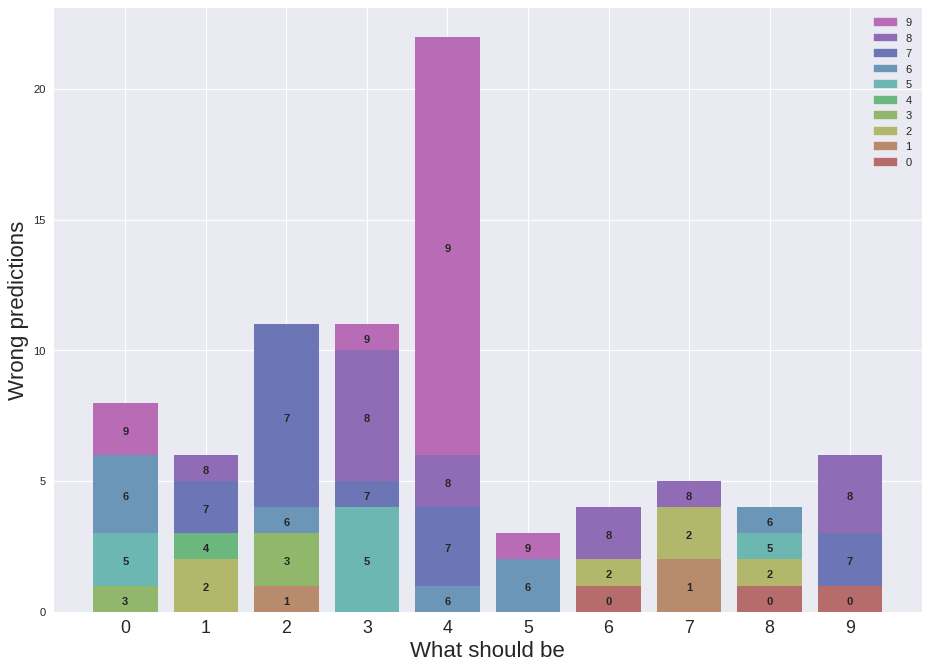

In [65]:
error_plot(decode_one_hot(wrong)[uncertain_errors], true[uncertain_errors])

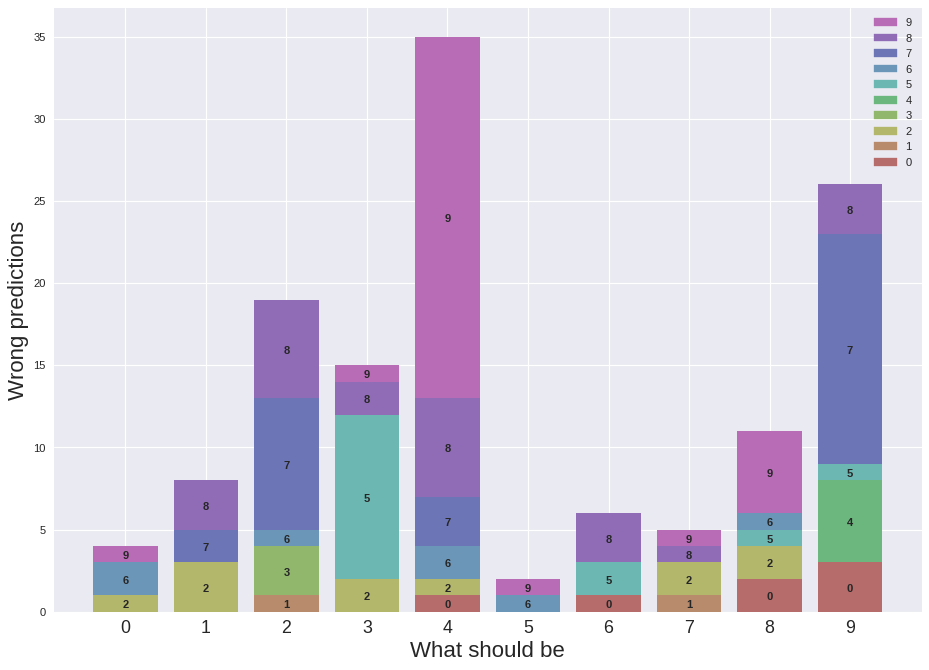

In [66]:
error_plot(decode_one_hot(wrong)[certain_errors], true[certain_errors])

In [67]:
def plot_images_in_grid(images, rows, max_cols):
    images_count = len(images)
    cols = min(max_cols, (images_count / max_cols) + 1)

    fig, axes = plt.subplots(rows, cols, figsize=(16, 10))
    for i in range(rows):
        for j in range(cols):
            idx = i*rows + j
            if idx < images_count:
                axes[i, j].imshow(images[idx])
                axes[i, j].axis('off')

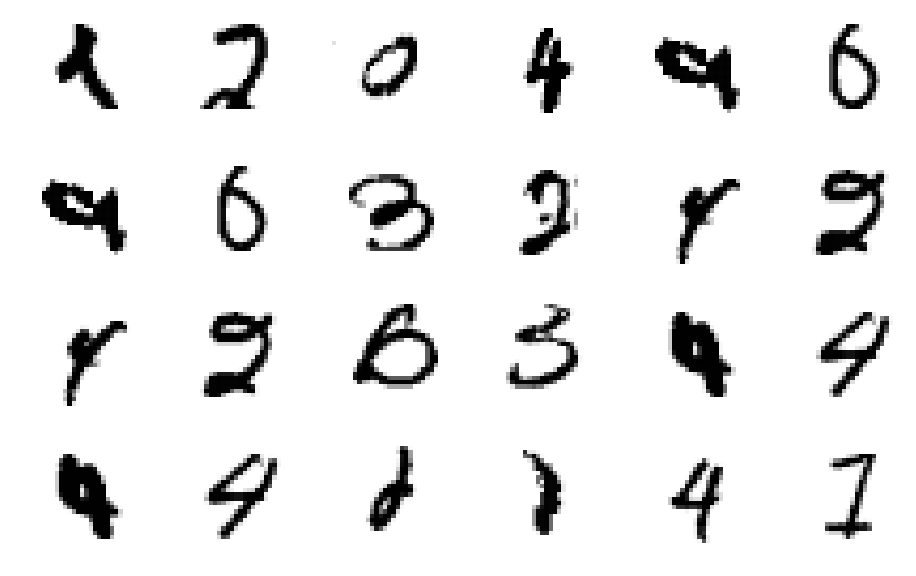

In [68]:
uncertain_images = train[error_idx][uncertain_errors].loc[:, 'pixel0':].as_matrix().reshape((-1, 28, 28))
plot_images_in_grid(uncertain_images, 4, 6)

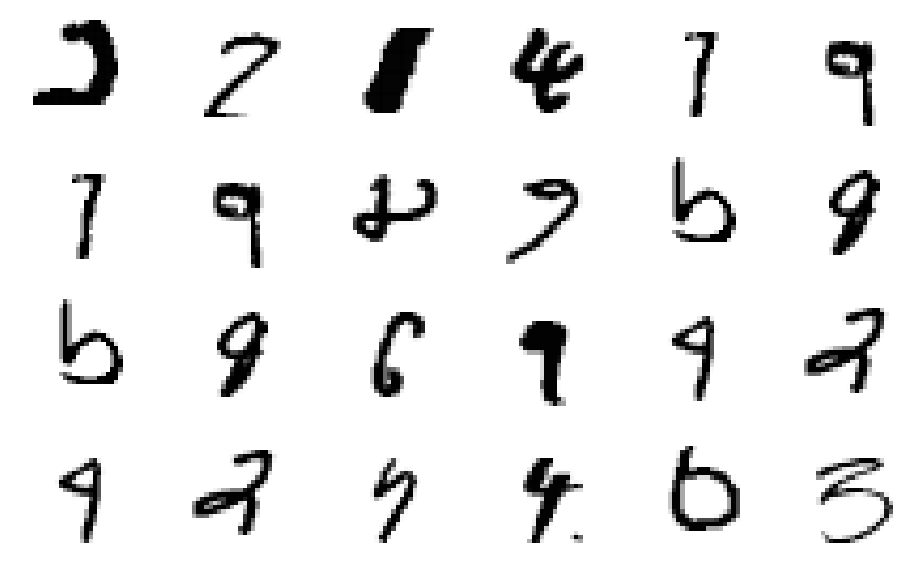

In [69]:
certain_images = train[error_idx][certain_errors].loc[:, 'pixel0':].as_matrix().reshape((-1, 28, 28))
plot_images_in_grid(certain_images, 4, 6)